In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.nn.functional as F


from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.image_paths = image_paths
        self.label_paths = label_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image using PIL
        with Image.open(self.image_paths[idx]) as img:
            np_image = np.array(img, dtype=np.float32)

        # Normalize the image
        normalized_image = np_image / 65535.0  # Assuming 16-bit images

        # Load and process the label data using PIL
        with Image.open(self.label_paths[idx]) as label_img:
            label_array = np.array(label_img, dtype=np.float32)

        grayscale_to_class_mapping = {0: 0, 128: 1, 255: 2} # Maps gray-levels to class

        # Map grayscale values to class labels
        mapped_labels = np.copy(label_array)
        for grayscale_value, class_id in grayscale_to_class_mapping.items():
            mapped_labels[label_array == grayscale_value] = class_id

        # Convert to PyTorch tensors
        image_tensor = torch.from_numpy(normalized_image).unsqueeze(0) # Add channel dimension
        label_tensor = torch.from_numpy(mapped_labels).long() # Ensure label tensor is long type

        return image_tensor, label_tensor


In [3]:
### Label images ###
# white class - 255 nickel
# gray class - 128 ysz
# black class - 0 pores

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Define a helper function for creating a block
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Dropout(p=0.1)
            )

        # Encoder
        self.e11 = conv_block(1, 64)
        self.e12 = conv_block(64, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = conv_block(64, 128)
        self.e22 = conv_block(128, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = conv_block(128, 256)
        self.e32 = conv_block(256, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = conv_block(256, 512)
        self.e42 = conv_block(512, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = conv_block(512, 1024)
        self.e52 = conv_block(1024, 1024)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = conv_block(1024, 512)
        self.d12 = conv_block(512, 512)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = conv_block(512, 256)
        self.d22 = conv_block(256, 256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = conv_block(256, 128)
        self.d32 = conv_block(128, 128)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = conv_block(128, 64)
        self.d42 = conv_block(64, 64)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = self.e11(x)
        xe12 = self.e12(xe11)
        xp1 = self.pool1(xe12)

        xe21 = self.e21(xp1)
        xe22 = self.e22(xe21)
        xp2 = self.pool2(xe22)

        xe31 = self.e31(xp2)
        xe32 = self.e32(xe31)
        xp3 = self.pool3(xe32)

        xe41 = self.e41(xp3)
        xe42 = self.e42(xe41)
        xp4 = self.pool4(xe42)

        xe51 = self.e51(xp4)
        xe52 = self.e52(xe51)

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = self.d11(xu11)
        xd12 = self.d12(xd11)

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = self.d21(xu22)
        xd22 = self.d22(xd21)

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = self.d31(xu33)
        xd32 = self.d32(xd31)

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = self.d41(xu44)
        xd42 = self.d42(xd41)

        # Output layer
        out = self.outconv(xd42)

        return out

In [4]:
from torch.utils.data import DataLoader, random_split
from torch import optim
import torch
import os
import matplotlib.pyplot as plt

def dice_coefficient(predicted, target, num_classes):
    dice_scores = []  # To store dice coefficient for each class

    # Convert predictions and targets to one-hot encoded form
    predicted_one_hot = F.one_hot(predicted, num_classes).permute(0, 3, 1, 2).float()
    target_one_hot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float()

    # Calculate Dice coefficient for each class
    for class_index in range(num_classes):
        intersection = (predicted_one_hot[:, class_index, :, :] * target_one_hot[:, class_index, :, :]).sum()
        union = predicted_one_hot[:, class_index, :, :].sum() + target_one_hot[:, class_index, :, :].sum()
        dice_score = (2 * intersection + 1e-6) / (union + 1e-6)  # Adding a small epsilon to avoid division by zero
        dice_scores.append(dice_score)

    # Average Dice score across all classes
    avg_dice_score = sum(dice_scores) / len(dice_scores)
    return avg_dice_score.item()  # Return the value as a Python scalar

def get_image_paths(data_dir, label_dir):
    data_paths = [os.path.join(data_dir, img) for img in sorted(os.listdir(data_dir))]
    label_paths = [os.path.join(label_dir, lbl) for lbl in sorted(os.listdir(label_dir))]
    return data_paths, label_paths

def create_subsets(dataset, subset_sizes):
    subsets = {}
    for size in subset_sizes:
        if size == len(dataset):
            subsets[size] = dataset  # Use the full dataset
        else:
            subset, _ = random_split(dataset, [size, len(dataset) - size])
            subsets[size] = subset
    return subsets

def plot_predictions(images, actuals, predicted):
    plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
    for i in range(len(images)):
        # Rescale the images from [0, 1] to [0, 65535]
        image = images[i].squeeze() * 65535

        # Contrast stretching the original image for visualization (directly doing 16bit to 8bit got fucked)
        vmin, vmax = image.min(), image.max()
        image = (image - vmin) / (vmax - vmin)  # Scale pixel values to 0-1 range
        image = (image * 255).to(torch.uint8).cpu().numpy()  # Scale up to 0-255 range and convert to 8-bit

        # Display the original image
        plt.subplot(1, len(images)*3, i*3+1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Original Image')
        plt.axis('off')

        # Display the actual label image
        actual = actuals[i].squeeze()  # Assuming actuals is a batch of label images
        plt.subplot(1, len(images)*3, i*3+2)
        plt.imshow(actual, cmap='gray')
        plt.title(f'Actual Label')
        plt.axis('off')

        # Display the predicted label image
        pred = predicted[i].squeeze()  # Assuming predicted is a batch of label images
        plt.subplot(1, len(images)*3, i*3+3)
        plt.imshow(pred, cmap='gray')
        plt.title(f'Predicted Label')
        plt.axis('off')

    plt.show()


Using cuda

Training on subset size: 100
Epoch 1/250, Batch 1/3, Loss: 1.1048831939697266
Validation Loss after Epoch 1: 1.0918713808059692
Epoch 2/250, Batch 1/3, Loss: 0.8326792120933533
Validation Loss after Epoch 2: 1.0770385265350342
Epoch 3/250, Batch 1/3, Loss: 0.7375583648681641
Validation Loss after Epoch 3: 1.0553982257843018
Epoch 4/250, Batch 1/3, Loss: 0.6643237471580505
Validation Loss after Epoch 4: 1.043819546699524
Epoch 5/250, Batch 1/3, Loss: 0.6203867793083191
Validation Loss after Epoch 5: 1.0650546550750732
Epoch 6/250, Batch 1/3, Loss: 0.5677503943443298
Validation Loss after Epoch 6: 1.1324055194854736
Epoch 7/250, Batch 1/3, Loss: 0.5216399431228638
Validation Loss after Epoch 7: 1.2057721614837646
Epoch 8/250, Batch 1/3, Loss: 0.4835641384124756
Validation Loss after Epoch 8: 1.2749710083007812
Epoch 9/250, Batch 1/3, Loss: 0.4536415636539459
Validation Loss after Epoch 9: 1.3010973930358887
Epoch 10/250, Batch 1/3, Loss: 0.4059072434902191
Validation Loss aft

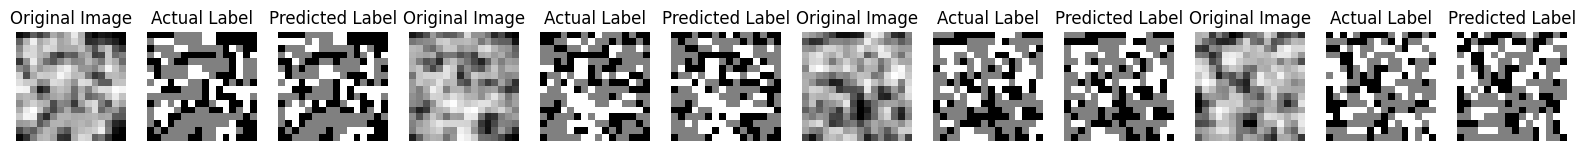


Training on subset size: 250
Epoch 1/250, Batch 1/6, Loss: 1.130179762840271
Validation Loss after Epoch 1: 1.0731057524681091
Epoch 2/250, Batch 1/6, Loss: 0.7414453625679016
Validation Loss after Epoch 2: 1.0557710528373718
Epoch 3/250, Batch 1/6, Loss: 0.6087232828140259
Validation Loss after Epoch 3: 1.1927708983421326
Epoch 4/250, Batch 1/6, Loss: 0.5238410234451294
Validation Loss after Epoch 4: 1.3568835854530334
Epoch 5/250, Batch 1/6, Loss: 0.44951722025871277
Validation Loss after Epoch 5: 1.3714237213134766
Epoch 6/250, Batch 1/6, Loss: 0.3672674298286438
Validation Loss after Epoch 6: 1.3150306940078735
Epoch 7/250, Batch 1/6, Loss: 0.31790387630462646
Validation Loss after Epoch 7: 0.9434069693088531
Epoch 8/250, Batch 1/6, Loss: 0.266347736120224
Validation Loss after Epoch 8: 0.600145697593689
Epoch 9/250, Batch 1/6, Loss: 0.23237264156341553
Validation Loss after Epoch 9: 0.4297711104154587
Epoch 10/250, Batch 1/6, Loss: 0.2080106884241104
Validation Loss after Epoch 1

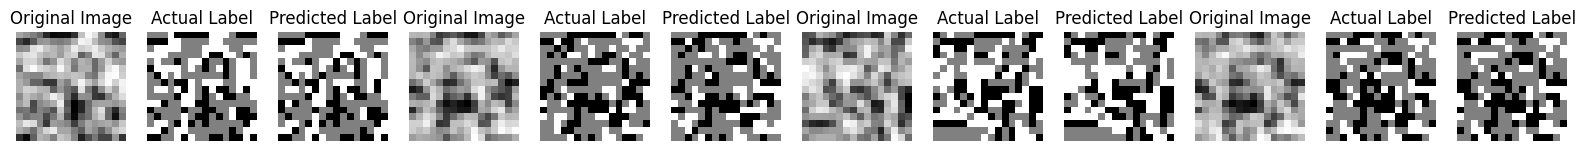


Training on subset size: 500
Epoch 1/250, Batch 1/11, Loss: 1.1715457439422607
Epoch 1/250, Batch 11/11, Loss: 0.6679294109344482
Validation Loss after Epoch 1: 1.0557257334391277
Epoch 2/250, Batch 1/11, Loss: 0.6519837975502014
Epoch 2/250, Batch 11/11, Loss: 0.5108425617218018
Validation Loss after Epoch 2: 1.2789671818415325
Epoch 3/250, Batch 1/11, Loss: 0.48735538125038147
Epoch 3/250, Batch 11/11, Loss: 0.399983286857605
Validation Loss after Epoch 3: 1.2876672347386677
Epoch 4/250, Batch 1/11, Loss: 0.3746614456176758
Epoch 4/250, Batch 11/11, Loss: 0.2903432548046112
Validation Loss after Epoch 4: 0.9286861419677734
Epoch 5/250, Batch 1/11, Loss: 0.26852625608444214
Epoch 5/250, Batch 11/11, Loss: 0.2298412322998047
Validation Loss after Epoch 5: 0.5281694928805033
Epoch 6/250, Batch 1/11, Loss: 0.2115282267332077
Epoch 6/250, Batch 11/11, Loss: 0.19963009655475616
Validation Loss after Epoch 6: 0.2377903958161672
Epoch 7/250, Batch 1/11, Loss: 0.18315471708774567
Epoch 7/250

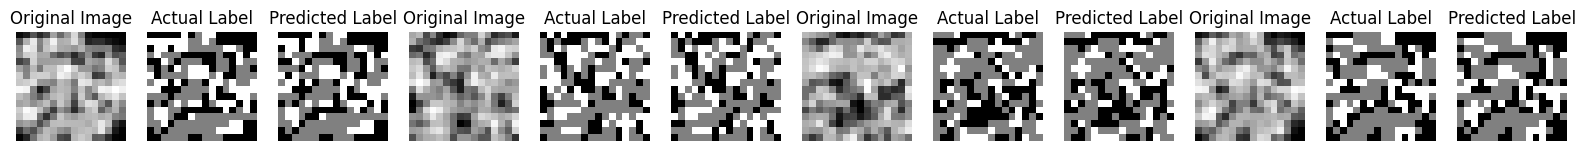

In [5]:
# Define your dataset paths
data_dir = '/content/gdrive/MyDrive/training_dataset/data_resize16/'
label_dir = '/content/gdrive/MyDrive/training_dataset/label_resize16/'

# Get image paths and create the full dataset
image_paths, label_paths = get_image_paths(data_dir, label_dir)
dataset = CustomDataset(image_paths=image_paths, label_paths=label_paths)

# Define subset sizes including the full dataset size
subset_size = [100, 250, len(dataset)]  # Add the full dataset size

# Create subsets
dataset_subsets = create_subsets(dataset, subset_size)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# Training configurations
learning_rate = 0.001
num_epochs = 250  # Adjust as needed

# Loop over subsets and train the model
for size, subset in dataset_subsets.items():
    print(f"\nTraining on subset size: {size}")


    # Split the subset into training, validation, and test datasets
    train_size = int(0.70 * len(subset))
    val_size = int(0.15 * len(subset))
    test_size = len(subset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(subset, [train_size, val_size, test_size])

    # DataLoader setup
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, loss function, and optimizer setup
    model = UNet(n_class=3).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            labels = labels.squeeze(1).long()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}")

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                labels = labels.squeeze(1).long()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
            val_loss /= len(val_loader)
            print(f"Validation Loss after Epoch {epoch+1}: {val_loss}")

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total = 0
        dice_scores = []

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probabilities, 1)
            labels = labels.squeeze(1).long()

            loss = criterion(outputs, labels)
            test_loss += loss.item()
            total += labels.numel()
            correct += (predicted == labels).sum().item()

            dice_score = dice_coefficient(predicted, labels, num_classes=3)
            dice_scores.append(dice_score)

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        average_dice_score = sum(dice_scores) / len(dice_scores)

        print(f"Subset size {size} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Average Dice Score: {average_dice_score:.4f}")

        # Select a few images (e.g., first 4)
        selected_images = images[:4].cpu()
        actual_labels = labels[:4].cpu()
        predicted_labels = predicted[:4].cpu()

        # Call the function
        plot_predictions(selected_images, actual_labels, predicted_labels)